# Imporation des packages

In [1]:
# Import des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

In [2]:
# Charger la base de données Boston Housing
from sklearn.datasets import load_boston
boston = load_boston()
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['PRICE'] = boston.target
print(data.head())


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


/Users/natachanjongwayepnga/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the C

In [3]:
# Desciption de la base de données
data.describe()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Identification graphique des outliers

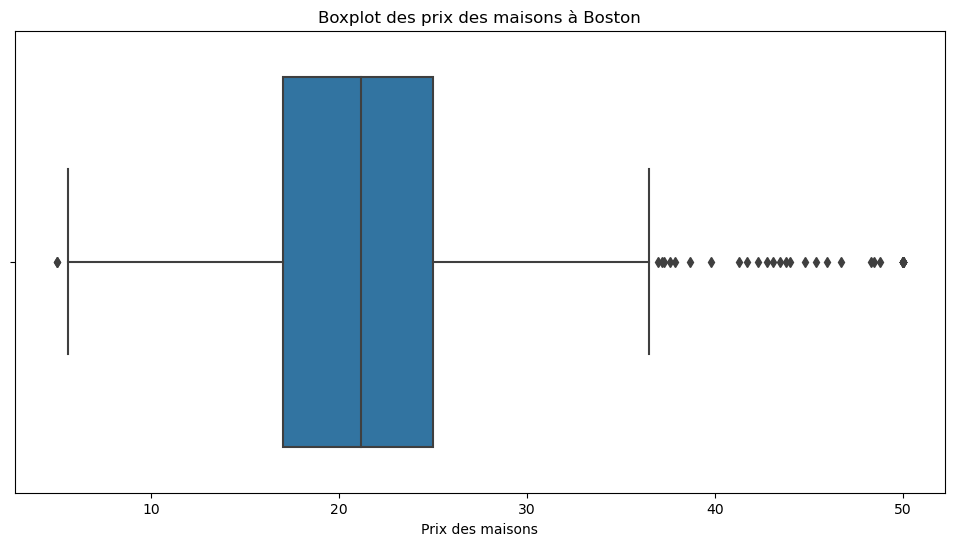

In [4]:
# Visualiser les outliers en utilisant un boxplot avec Seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='PRICE')
plt.xlabel('Prix des maisons')
plt.title("Boxplot des prix des maisons à Boston")
plt.show()

# Identification des outliers univariées

## Identification des outliers IQR

La méthode de l'IQR est une approche courante pour identifier les valeurs aberrantes dans des données univariées. Elle utilise l'écart interquartile pour définir une plage de valeurs plausibles et identifie les observations qui sont en dehors de cette plage.

### Définition

L'IQR est défini comme la différence entre le troisième quartile (Q3) et le premier quartile (Q1) de la distribution des données. Les bornes inférieure et supérieure de la plage plausible sont définies comme suit :

- Limite inférieure : Q1 - 1,5 x IQR
- Limite supérieure : Q3 + 1,5 x IQR

Les observations en dehors de ces bornes sont considérées comme des valeurs aberrantes.

### Avantages

La méthode de l'IQR est relativement simple à comprendre et à implémenter. Elle est également assez robuste aux valeurs aberrantes, car elle utilise la médiane et l'écart interquartile pour calculer les bornes plausibles.

### Inconvénients

La méthode de l'IQR peut ne pas fonctionner correctement dans certaines distributions non symétriques, car elle suppose une distribution normale ou presque normale des données. Elle peut également ne pas fonctionner correctement si les données contiennent de nombreux points de données aberrants.


In [5]:
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(data, 'PRICE')

# Afficher les outliers
print("Outliers détectés:")
print(outliers)

Outliers détectés:
         CRIM    ZN  INDUS  CHAS     NOX     RM    AGE     DIS   RAD    TAX  \
97    0.12083   0.0   2.89   0.0  0.4450  8.069   76.0  3.4952   2.0  276.0   
98    0.08187   0.0   2.89   0.0  0.4450  7.820   36.9  3.4952   2.0  276.0   
157   1.22358   0.0  19.58   0.0  0.6050  6.943   97.4  1.8773   5.0  403.0   
161   1.46336   0.0  19.58   0.0  0.6050  7.489   90.8  1.9709   5.0  403.0   
162   1.83377   0.0  19.58   1.0  0.6050  7.802   98.2  2.0407   5.0  403.0   
163   1.51902   0.0  19.58   1.0  0.6050  8.375   93.9  2.1620   5.0  403.0   
166   2.01019   0.0  19.58   0.0  0.6050  7.929   96.2  2.0459   5.0  403.0   
179   0.05780   0.0   2.46   0.0  0.4880  6.980   58.4  2.8290   3.0  193.0   
180   0.06588   0.0   2.46   0.0  0.4880  7.765   83.3  2.7410   3.0  193.0   
182   0.09103   0.0   2.46   0.0  0.4880  7.155   92.2  2.7006   3.0  193.0   
186   0.05602   0.0   2.46   0.0  0.4880  7.831   53.6  3.1992   3.0  193.0   
190   0.09068  45.0   3.44   0.0 

## Identification des outliers avec Z-score

## Méthode du z-score

La méthode du z-score est une autre approche courante pour identifier les valeurs aberrantes dans des données univariées. Elle utilise l'écart à la moyenne pour définir une plage de valeurs plausibles et identifie les observations qui sont en dehors de cette plage.

### Définition

Le z-score est défini comme la différence entre une observation et la moyenne de la distribution des données, divisée par l'écart-type de la distribution :

z = (x - μ) / σ

Les bornes inférieure et supérieure de la plage plausible sont définies comme suit :

- Limite inférieure : μ - 3 x σ
- Limite supérieure : μ + 3 x σ

Les observations en dehors de ces bornes sont considérées comme des valeurs aberrantes.

### Avantages

La méthode du z-score est également relativement simple à comprendre et à implémenter. Elle est également assez robuste aux valeurs aberrantes, car elle utilise la moyenne et l'écart-type pour calculer les bornes plausibles.

### Inconvénients

Comme pour la méthode de l'IQR, la méthode du z-score peut ne pas fonctionner correctement dans certaines distributions non symétriques. Elle peut également ne pas fonctionner correctement si les données contiennent de nombreux points de données aberrants.

In [6]:

# Identification des données aberrantes - Z-score
# Fonction pour détecter les outliers en utilisant le z-score
def detect_outliers_zscore(data, column, threshold=2):
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    return data[np.abs(z_scores) > threshold]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_zscore(data, 'PRICE')

# Afficher les outliers
print("Outliers détectés:")
print(outliers)


Outliers détectés:
        CRIM    ZN  INDUS  CHAS     NOX     RM    AGE     DIS   RAD    TAX  \
98   0.08187   0.0   2.89   0.0  0.4450  7.820   36.9  3.4952   2.0  276.0   
157  1.22358   0.0  19.58   0.0  0.6050  6.943   97.4  1.8773   5.0  403.0   
161  1.46336   0.0  19.58   0.0  0.6050  7.489   90.8  1.9709   5.0  403.0   
162  1.83377   0.0  19.58   1.0  0.6050  7.802   98.2  2.0407   5.0  403.0   
163  1.51902   0.0  19.58   1.0  0.6050  8.375   93.9  2.1620   5.0  403.0   
166  2.01019   0.0  19.58   0.0  0.6050  7.929   96.2  2.0459   5.0  403.0   
186  0.05602   0.0   2.46   0.0  0.4880  7.831   53.6  3.1992   3.0  193.0   
195  0.01381  80.0   0.46   0.0  0.4220  7.875   32.0  5.6484   4.0  255.0   
202  0.02177  82.5   2.03   0.0  0.4150  7.610   15.7  6.2700   2.0  348.0   
203  0.03510  95.0   2.68   0.0  0.4161  7.853   33.2  5.1180   4.0  224.0   
204  0.02009  95.0   2.68   0.0  0.4161  8.034   31.9  5.1180   4.0  224.0   
224  0.31533   0.0   6.20   0.0  0.5040  8.26

# Identification des outliers avec des approches multivariées

## Analyse graphique

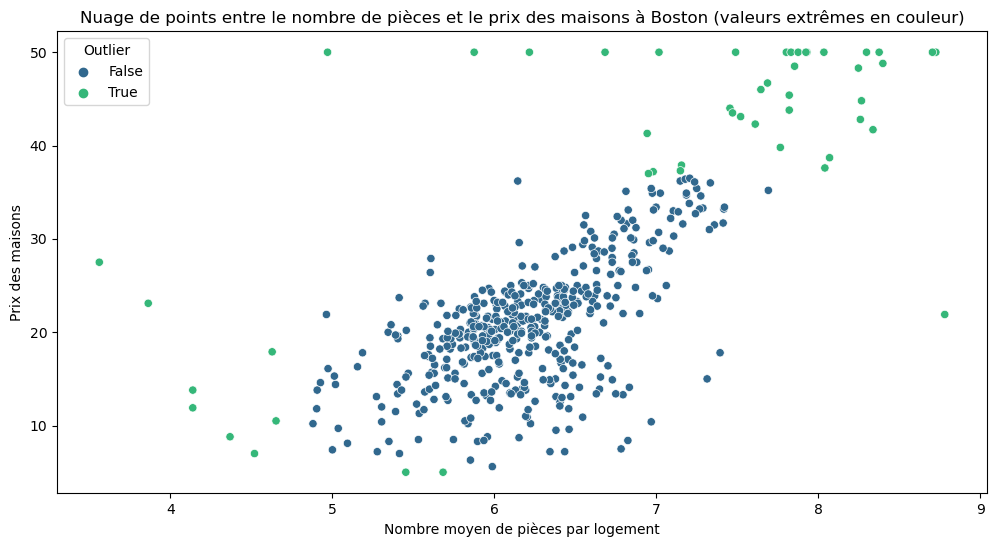

In [8]:

# Détecter les outliers pour les colonnes 'RM' et 'PRICE'
outliers_rm = detect_outliers_iqr(data, 'RM')
outliers_price = detect_outliers_iqr(data, 'PRICE')

# Ajouter une colonne pour indiquer si la valeur est extrême
data['Outlier'] = False
data.loc[outliers_rm.index, 'Outlier'] = True
data.loc[outliers_price.index, 'Outlier'] = True

# Créer un nuage de points (scatter plot) avec Seaborn en mettant en évidence les valeurs extrêmes
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='RM', y='PRICE', hue='Outlier', palette='viridis')
plt.xlabel('Nombre moyen de pièces par logement')
plt.ylabel('Prix des maisons')
plt.title("Nuage de points entre le nombre de pièces et le prix des maisons à Boston (valeurs extrêmes en couleur)")
plt.show()

## Isolation Forest



L'Isolation Forest est une méthode d'apprentissage automatique non supervisée pour identifier les valeurs aberrantes dans des données univariées et multivariées. **Elle fonctionne en construisant plusieurs arbres de décision aléatoires** et en calculant un score d'anomalie pour chaque observation en fonction de la profondeur moyenne à laquelle elle est isolée des autres observations.

### Définition

**L'Isolation Forest est basée sur l'idée que les valeurs aberrantes sont plus faciles à isoler que les valeurs normales**. Elle construit plusieurs arbres de décision aléatoires et divise les données en sous-ensembles aléatoires à chaque nœud. L'algorithme isole les observations en fonction de la profondeur moyenne à laquelle elles sont isolées par rapport aux autres observations. Les observations qui sont isolées plus rapidement que la moyenne sont considérées comme des valeurs aberrantes.

### Avantages

**L'Isolation Forest est capable de détecter les valeurs aberrantes dans des données univariées et multivariées**. Elle fonctionne également bien avec des **distributions non symétriques** et est assez robuste aux valeurs aberrantes. 


### Inconvénients

L'Isolation Forest peut être sensible aux paramètres tels que le nombre d'arbres et la taille des sous-échantillons. De plus, elle peut parfois être difficile à interpréter, en particulier pour les données multivariées.


In [9]:
from sklearn.ensemble import IsolationForest

# Appliquer l'Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(data)

# Ajouter les labels d'anomalie au DataFrame
data['Outlier'] = outlier_labels

# Afficher les outliers
outliers = data[data['Outlier'] == -1]
print("Outliers détectés:")
print(outliers)

Outliers détectés:
         CRIM    ZN  INDUS  CHAS     NOX     RM    AGE     DIS   RAD    TAX  \
142   3.32105   0.0  19.58   1.0  0.8710  5.403  100.0  1.3216   5.0  403.0   
145   2.37934   0.0  19.58   0.0  0.8710  6.130  100.0  1.4191   5.0  403.0   
152   1.12658   0.0  19.58   1.0  0.8710  5.012   88.0  1.6102   5.0  403.0   
154   1.41385   0.0  19.58   1.0  0.8710  6.129   96.0  1.7494   5.0  403.0   
155   3.53501   0.0  19.58   1.0  0.8710  6.152   82.6  1.7455   5.0  403.0   
156   2.44668   0.0  19.58   0.0  0.8710  5.272   94.0  1.7364   5.0  403.0   
157   1.22358   0.0  19.58   0.0  0.6050  6.943   97.4  1.8773   5.0  403.0   
161   1.46336   0.0  19.58   0.0  0.6050  7.489   90.8  1.9709   5.0  403.0   
162   1.83377   0.0  19.58   1.0  0.6050  7.802   98.2  2.0407   5.0  403.0   
163   1.51902   0.0  19.58   1.0  0.6050  8.375   93.9  2.1620   5.0  403.0   
166   2.01019   0.0  19.58   0.0  0.6050  7.929   96.2  2.0459   5.0  403.0   
190   0.09068  45.0   3.44   0.0 

/Users/natachanjongwayepnga/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


# Solutions pour traiter les valeurs extrêmes

| Type de valeur aberrante | Solutions pour les traiter                                                                                              |
|--------------------------|------------------------------------------------------------------------------------------------------------------------|
| Erreur                   | 1. Correction de l'erreur si possible (ex. erreurs de saisie)                                                           |
|                          | 2. Suppression de l'observation si la correction n'est pas possible et si l'erreur est clairement une anomalie 
|                          | 3. Remplacer par une valeur manquante et imputer avec les techniques d'imputation
|                          |      |
| Extrême                  | 1. Transformation des données (ex. logarithmique, racine carrée) pour réduire l'impact des valeurs extrêmes             |
|                          | 2. Winsorisation : remplacer les valeurs extrêmes par des percentiles spécifiques (ex. 1er et 99e percentiles)          |
|                         
|                          | 3. Utiliser des modèles d'apprentissage automatique robustes aux valeurs extrêmes (ex. modèles basés sur les rangs)     |
|                          | 4. Discrétiser la variable   |
|                          | 5. Faire le modèle avec et sans les valeurs extrêmes et analyser l'impact   |